
# Clean the merged dataset


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def string_to_float(input_Series: pd.Series) -> pd.Series:
    """Converts a 'numeric' Series of dtype string to dtype float.
    
    Keyword Arguments:
    input_Series -- a pandas Series to be converted from str to float
    """
    return input_Series.apply(str.replace, args=(',', '')).astype(np.float64)


def get_quarters(input_df: pd.DataFrame) -> list:
    """Gake a list of quarters in the data."""
    quarters = set()
    for column in input_df.columns:
        if column[-2] == 'Q':
            quarters.add(column[-7:])
    # Drop 2024Q1 if needed:
    if 'Revenue_2024Q1' not in input_df.columns:
        quarters.discard('_2024Q1')
    quarters = sorted(list(quarters))
    return quarters


def clean(input_df: pd.DataFrame) -> pd.DataFrame:
    """Cleans the dataframe.
    
    This function is not very modular.  It uses column names that are
    specific to the Russell_3000 data. 
    """
    dataset = input_df.copy()
    quarters = get_quarters(dataset)
    # Drop duplicates
    dataset.drop_duplicates(inplace=True)
    duplicated_rows = dataset[dataset.duplicated()]
    print(f'Duplicated rows remaining: {duplicated_rows.shape[0]}')
          
    # Drop where ticker is duplicated
    duplicates = dataset.loc[(
        dataset.duplicated('Ticker', keep=False)
    )].sort_values('Ticker')
    dataset.drop(index=list(duplicates.index), inplace=True)
    duplicated_Tickers = dataset[dataset.duplicated('Ticker')]
    print(f'Duplicated Tickers remaining: {duplicated_Tickers.shape[0]}')
    
    # Keep only entries that are classified as Equity
    dataset = dataset[dataset['Asset Class'] == 'Equity'].copy()
    print(f'Asset Classes remaining: {dataset['Asset Class'].unique()}')
    
    # Keep only companies in NASDAQ and NYSE
    exchanges_to_keep = ['NASDAQ', 'New York Stock Exchange Inc.']
    dataset = dataset[dataset['Exchange'].isin(exchanges_to_keep)].copy()
    print(f'Exchanges remaining: {dataset.Exchange.unique()}')
    
   # Drop companies where key variables are zero (90 total in Russell_3000)
    non_zero_cols = ['Revenue', 'TotalAssets', 'TotalEquity', 'CurrentLiabilities']
    indexes_to_drop = set()
    for column in non_zero_cols:
        for quarter in quarters:
            index_where_zero = dataset[dataset[column + quarter] == 0].index
        for index in index_where_zero:
            indexes_to_drop.add(index)
    dataset.drop(index=indexes_to_drop, inplace=True)
    print(f'Dropped {len(indexes_to_drop)} rows with value zero (0) in: {non_zero_cols}.')
    
    # Modify Location using One-Hot-Encoding
    # 1 = company in U.S., 0 = company outside U.S.
    locations = [location for location in dataset['Location'].unique()]
    replace_dict = {}
    for location in locations:
        if location == 'United States':
            replace_dict[location] = 1
        else:
            replace_dict[location] = 0
    dataset['Location'] = dataset['Location'].replace(replace_dict)
    new_locations = dataset.Location.unique()
    print(f'Unique values for Location (1=U.S., 0=outside U.S.): {new_locations}')
        
    # Convert columns with string values to floating point
    for column in ['Market Value']:
        dataset[column] = string_to_float(dataset[column])
    print(f'Market Value is now of type {dataset['Market Value'].dtype}')
    
    # Drop unnecessary or problematic columns
    columns_to_drop = ['ShortTermDebtOrCurrentLiab' + quarter for quarter in quarters]
    columns_to_drop = ['OriginalTicker',
                       'YahooSymbol',
                       'Asset Class',
                       'Currency',
                       'Weight (%)',
                       'Price',
                       'Quantity',
                       'Notional Value'
                      ] + columns_to_drop
    dataset.drop(columns=columns_to_drop, inplace=True)
    print('\nDropped the following columns:')
    for column in columns_to_drop:
        print(column)

    # Report final status
    print('\nColumns remaining:')
    for column in dataset.columns:
        print(column)
    print(f'{dataset.shape[1]} columns (features) remaining.')
    print(f'{dataset.shape[0]} rows (companies) remaining.')
    return dataset

    

In [4]:
pd.set_option("future.no_silent_downcasting", True)


## Import data


In [5]:
# Import base data (Russell_3000)
path = 'data/'
filename = 'Russell_3000_With_Macro.csv'
input_df = pd.read_csv(path + filename)


## Clean data


In [6]:
dataset = clean(input_df)

Duplicated rows remaining: 0
Duplicated Tickers remaining: 0
Asset Classes remaining: ['Equity']
Exchanges remaining: ['NASDAQ' 'New York Stock Exchange Inc.']
Dropped 90 rows with value zero (0) in: ['Revenue', 'TotalAssets', 'TotalEquity', 'CurrentLiabilities'].
Unique values for Location (1=U.S., 0=outside U.S.): [1 0]
Market Value is now of type float64

Dropped the following columns:
OriginalTicker
YahooSymbol
Asset Class
Currency
Weight (%)
Price
Quantity
Notional Value
ShortTermDebtOrCurrentLiab_2024Q2
ShortTermDebtOrCurrentLiab_2024Q3
ShortTermDebtOrCurrentLiab_2024Q4
ShortTermDebtOrCurrentLiab_2025Q1
ShortTermDebtOrCurrentLiab_2025Q2

Columns remaining:
Ticker
Name
Sector
CapitalExpenditure_2024Q2
CapitalExpenditure_2024Q3
CapitalExpenditure_2024Q4
CapitalExpenditure_2025Q1
CapitalExpenditure_2025Q2
CashAndSTInvestments_2024Q2
CashAndSTInvestments_2024Q3
CashAndSTInvestments_2024Q4
CashAndSTInvestments_2025Q1
CashAndSTInvestments_2025Q2
CashFromOps_2024Q2
CashFromOps_2024Q3
Ca


## Check for missing values

*credit to [Michael P. Notter](https://miykael.github.io/blog/2022/advanced_eda/) for sharing these techniques!*

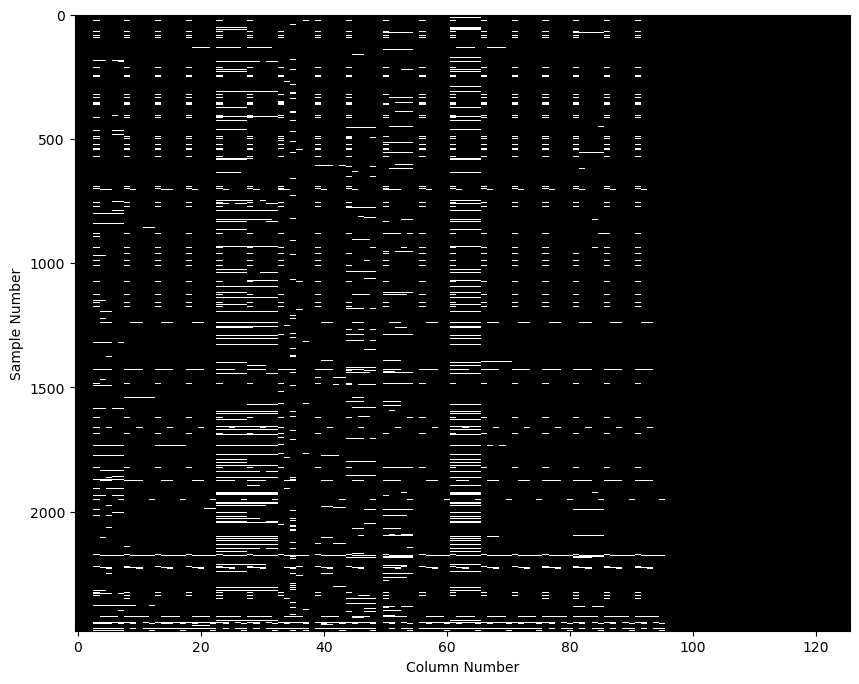

In [8]:
# Missing values show in white in the figure
plt.figure(figsize=(10, 8))
plt.imshow(dataset.isna(), aspect='auto', interpolation='nearest', cmap='gray')
plt.xlabel('Column Number')
plt.ylabel('Sample Number')
plt.show()

In [9]:
# List features missing the most data
print(dataset.isna().mean().sort_values(ascending=False)[:20])

OperatingIncome_2024Q2       0.201210
CurrentAssets_2024Q2         0.189113
CurrentLiabilities_2024Q2    0.150403
OperatingIncome_2024Q3       0.148387
OperatingIncome_2024Q4       0.148387
OperatingIncome_2025Q2       0.145968
OperatingIncome_2025Q1       0.145565
CurrentAssets_2024Q3         0.134274
CurrentAssets_2025Q1         0.131855
CurrentAssets_2024Q4         0.131855
CurrentAssets_2025Q2         0.129032
LongTermDebt_2024Q2          0.110081
CapitalExpenditure_2024Q2    0.097984
CurrentLiabilities_2024Q3    0.093145
CurrentLiabilities_2025Q1    0.092742
EPS_2024Q4                   0.091935
CurrentLiabilities_2025Q2    0.086694
CurrentLiabilities_2024Q4    0.084274
InterestExpense_2024Q2       0.083065
TotalDebt_2024Q2             0.080242
dtype: float64


In [10]:
# dataset.to_csv(path + 'Russell_3000_Cleaned.csv', index=False)